In [2]:
from utils import process_csv
import numpy as np

In [3]:
cd /home/u1604520

/home/u1604520


In [4]:
confidence_level = 0.90
num_realizations = 100
num_methods = 2
seed = 0
B = 200 
m = 1
c = 1
T = 100

In [5]:
# theta star is [beta, ucontrol, utreatment] (npl) 
theta_star_b = np.array([2.8017219, 0.8963631, 2.1049698, 0.8133269])

theta_star_ucntrl = np.array([-0.0062962610 ,-0.0124886363 ,-0.0656259120,  0.0553920129,  0.0016368189,
 -0.1133628937, -0.0823724184, -0.1409955998, -0.1196572700, -0.2140463897,
 -0.2287150942, -0.1594304356, -0.1298448332, -0.0006475635, -0.0972845478,
 -0.0640575452,  0.0530625889, -0.1225419293,  0.0436204916, -0.0700521705,
 -0.0450052633, -0.1080204410, -0.1011592976, -0.0089961038, -0.0903640071,
 -0.0195710565,  0.0176386410, -0.0951353724,  0.0080870863, -0.0485360440])

theta_star_utrtmt = np.array([0.154291197,  0.077666984,  0.115663081,  0.049347918,  0.034666114,  0.040726930,
 -0.051816476, -0.143477886, -0.099363696, -0.342144260, -0.505408033, -0.811219698,
 -0.686494578, -0.644809594, -0.328456841,  0.073138617,  0.163276948,  0.276747908,
  0.139502494, -0.007725181,  0.185601587,  0.080644727,  0.045213061,  0.032665026,
  0.186584743,  0.010521884, -0.056215417, -0.072445351, -0.123186781,  0.026694320])

theta_star = np.concatenate([theta_star_b, theta_star_ucntrl, theta_star_utrtmt])

In [6]:
# folder_path = './results/mh/bcr_sim_data/'
folder_path = './results/mh/bcr_sim_data2/'
folder_path_bcr = './results/mh/bcr_sim_data_bcr/bcr_samples/'

In [7]:
import pandas as pd
import random

In [8]:
# for (k in 1:ncZ){
#   knots[k] = ((ncZ+1-k)*min(xg)+k*max(xg))/(ncZ+1)
# }

# reg_true <- numeric(n)
# for  (i in 1:n){
#   reg_true[i] <- mean_beta[2] + mean_beta[4]*xg[i]
#   for (k in 1:ncZ){
#     reg_true[i] <- (reg_true[i] + (mean_u_treatment[k]-mean_u_control[k])*(xg[i]-knots[k])*(xg[i]>knots[k]))
#   }
# }



In [9]:
def compute_ate(x, theta, knots):
    theta_b = theta[:4]
    theta_ucntrl = theta[4:34]
    theta_utrtmt = theta[34:]
    ate = np.zeros(len(x))
    for i in range(len(x)):
        ate[i] += theta_b[1] + theta_b[3]*x[i]
        for k in range(30):
            ate[i] += (theta_utrtmt[k] - theta_ucntrl[k])*(x[i]-knots[k])*max(0, x[i]-knots[k])
    return ate

In [10]:
mses = np.zeros((num_realizations, num_methods))
mses2 = np.zeros((num_realizations, num_methods, len(theta_star)))
stds = np.zeros((num_realizations, num_methods))
counts = np.zeros((num_methods, len(theta_star)))
coverage_probabilities = np.zeros((num_methods, len(theta_star)))
seed = 0
for r in range(num_realizations):    
    seed += 1
    path_data = f'./mh_study/sim_data_bcr/sim_data_bcr_{seed}.csv'
    data_control, data_treat = process_csv(path_data)
    boot_sample = np.loadtxt(folder_path+f'bootstrap_samples_bcr_{seed}.txt')
    # change order of beta to match bcr and theta star 
    boot_sample[:, [2, 1]] = boot_sample[:, [1, 2]]
    #bcr_sample = np.loadtxt(folder_path_bcr+f'bcr_sample_{seed}.txt')
    bcr_sample = pd.read_csv(folder_path_bcr+f'bcr_sample_{seed}.txt', delim_whitespace=True)
    
    mean_boot_sample = boot_sample.mean(axis=0)
    mean_bcr_sample = np.asarray(bcr_sample.mean(axis=1))
    
    np.random.seed(seed)
    x = np.random.randn(500)
    knots = np.zeros(30)
    for k in range(30):
        knots[k] = ((31-k)*min(x)+k*max(x))/31
        
    ate = compute_ate(x, theta_star, knots)
    ate_npl = compute_ate(x, mean_boot_sample, knots)
    ate_bcr = compute_ate(x, mean_bcr_sample, knots)
    
    mses[r, 0] = np.mean(np.asarray((ate_npl - ate)**2))
    mses[r, 1] = np.mean(np.asarray((ate_bcr - ate)**2))
    
       
    mses2[r, 0, :] = np.asarray((mean_boot_sample - theta_star)**2)
    mses2[r, 1, :] = np.asarray((mean_bcr_sample - theta_star)**2)

    
    # Credible interval 
    bcr_sample = np.asarray(bcr_sample).transpose()
    for i in range(len(theta_star)):
        count_npl = 0
        count_bcr = 0
        lower_bound = np.percentile(boot_sample[:, i], (1 - confidence_level) / 2 * 100)
        upper_bound = np.percentile(boot_sample[:, i], (1 + confidence_level) / 2 * 100)
        lower_bound_bcr = np.percentile(bcr_sample[:, i], (1 - confidence_level) / 2 * 100)
        upper_bound_bcr = np.percentile(bcr_sample[:, i], (1 + confidence_level) / 2 * 100)
        if lower_bound <= theta_star[i] <= upper_bound:
            count_npl += 1
        if lower_bound_bcr <= theta_star[i] <= upper_bound_bcr:
            count_bcr += 1
        counts[0, i] += count_npl
        counts[1, i] += count_bcr
            
# Calculate the coverage probability
coverage_probabilities[0, :] = counts[0, :] / num_realizations
coverage_probabilities[1, :] = counts[1, :] / num_realizations
mses_over_runs = np.mean(mses, axis=0)
mses_over_runs2 = np.mean(mses2, axis=0)
stds_mses_over_runs = np.std(mses, axis=0)
stds_mses_over_runs2 = np.std(mses2, axis=0)
        
print(f"Coverage Probabilities for Robust-MEM (MMD) : {coverage_probabilities[0, :] * 100}%")
print(f"Coverage Probabilities for BCR: {coverage_probabilities[1, :] * 100}%")
print(f"Mean Squared error res for Robust-MEM (MMD): {mses_over_runs[0]}")
print(f"Mean Squared error res for BCR: {mses_over_runs[1]}")
print(f"Mean Squared error param for Robust-MEM (MMD): {mses_over_runs2[0].mean()}")
print(f"Mean Squared error param for BCR: {mses_over_runs2[1].mean()}")

print(f"Std - Mean Squared error res for Robust-MEM (MMD): {stds_mses_over_runs[0]}")
print(f"Std - Mean Squared error res for BCR: {stds_mses_over_runs[1]}")
print(f"Std - Mean Squared error param for Robust-MEM (MMD): {stds_mses_over_runs2[0].mean()}")
print(f"Std - Mean Squared error param for BCR: {stds_mses_over_runs2[1].mean()}")

Coverage Probabilities for Robust-MEM (MMD) : [100. 100.  28. 100. 100. 100. 100. 100. 100. 100. 100. 100. 100. 100.
 100. 100. 100. 100. 100. 100. 100. 100. 100. 100. 100. 100. 100. 100.
 100. 100. 100. 100. 100. 100. 100. 100. 100. 100. 100. 100. 100. 100.
 100. 100.  56.   0.   0.   0. 100. 100. 100. 100. 100. 100. 100. 100.
 100. 100. 100. 100. 100. 100. 100. 100.]%
Coverage Probabilities for BCR: [ 99.  99.  98.  99. 100. 100. 100. 100. 100. 100. 100. 100. 100. 100.
 100. 100. 100. 100. 100. 100. 100. 100. 100. 100. 100. 100. 100. 100.
 100. 100. 100. 100. 100. 100. 100. 100. 100. 100. 100. 100. 100. 100.
 100. 100. 100. 100. 100. 100. 100. 100. 100. 100. 100. 100. 100. 100.
 100. 100. 100. 100. 100. 100. 100. 100.]%
Mean Squared error res for Robust-MEM (MMD): 29.662265969238693
Mean Squared error res for BCR: 101.91408861380887
Mean Squared error param for Robust-MEM (MMD): 0.10749816344558474
Mean Squared error param for BCR: 0.3650441989507498
Std - Mean Squared error res for 

In [11]:
coverage_probabilities.mean(axis=1)

array([0.935     , 0.99921875])

In [23]:
# Table
data_coverage = {'Param': [f'$theta_{i}$' for i in range(len(theta_star))], 'Robust-MEM (MMD)': coverage_probabilities[0, :], 'BCR': coverage_probabilities[1, :]}
df = pd.DataFrame(data_coverage)
cov_gb = df.groupby((['Param'])).mean()
#pivot_cov = cov_gb.pivot_table(index=['Param'], columns='$\sigma_\nu$', values=['Coverage prob.'])
cov_gb

,Robust-MEM (MMD),BCR
Param,,
$theta_0$,1.0,0.99
$theta_1$,1.0,0.99
$theta_10$,1.0,1.00
$theta_11$,1.0,1.00
$theta_12$,1.0,1.00
...,...,...
$theta_62$,1.0,1.00
$theta_63$,1.0,1.00
$theta_7$,1.0,1.00


In [ ]:
def create_dataframe(mse_array, std_array, method_name):
    
    data = {'MSE': mse_array, 'Std': std_array, 'Method': [method_name]*len(mse_array)}
    df = pd.DataFrame(data)
    
    return df

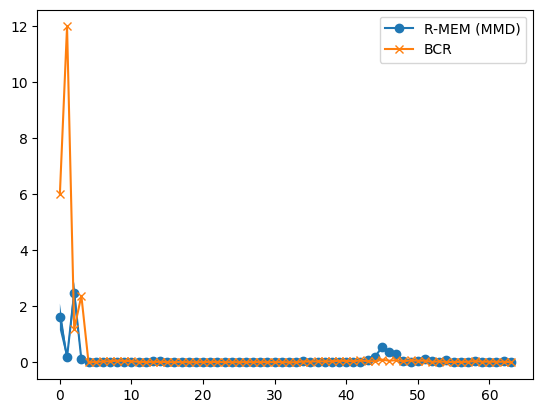

In [11]:
import matplotlib.pyplot as plt
plt.plot(range(len(theta_star)), mses_over_runs2[0,:], '-o', label='R-MEM (MMD)')
plt.fill_between(range(len(theta_star)), mses_over_runs2[0,:]-stds_mses_over_runs2[0,:], mses_over_runs2[0,:]+stds_mses_over_runs2[0,:])
plt.plot(range(len(theta_star)), mses_over_runs2[1,:], '-x', label='BCR')
plt.legend()


In [12]:
seed = 0
ates = np.zeros((num_realizations, 3, len(x)))
x = np.random.randn(500)
knots = np.zeros(30)
for k in range(30):
    knots[k] = ((31-k)*min(x)+k*max(x))/31
        
x_sorted = np.sort(x)
for r in range(num_realizations):
    seed += 1
    path_data = f'./mh_study/sim_data_bcr/sim_data_bcr_{seed}.csv'
    data_control, data_treat = process_csv(path_data)
    boot_sample = np.loadtxt(folder_path+f'bootstrap_samples_bcr_{seed}.txt')
    # change order of beta to match bcr and theta star 
    boot_sample[:, [2, 1]] = boot_sample[:, [1, 2]]
    #bcr_sample = np.loadtxt(folder_path_bcr+f'bcr_sample_{seed}.txt')
    bcr_sample = pd.read_csv(folder_path_bcr+f'bcr_sample_{seed}.txt', delim_whitespace=True)
    
    mean_boot_sample = boot_sample.mean(axis=0)
    mean_bcr_sample = np.asarray(bcr_sample.mean(axis=1))
    
    
    ate = compute_ate(x_sorted, theta_star, knots)
    ate_npl = compute_ate(x_sorted, mean_boot_sample, knots)
    ate_bcr = compute_ate(x_sorted, mean_bcr_sample, knots)
    
    ates[r, 0, :] = ate
    ates[r, 1, :] = ate_npl
    ates[r, 2, :] = ate_bcr

In [13]:
def lighten_color(color, amount=0.5):
    """
    From: https://stackoverflow.com/questions/37765197/darken-or-lighten-a-color-in-matplotlib
    Lightens the given color by multiplying (1-luminosity) by the given amount.
    Input can be matplotlib color string, hex string, or RGB tuple.

    Examples:
    >> lighten_color('g', 0.3)
    >> lighten_color('#F034A3', 0.6)
    >> lighten_color((.3,.55,.1), 0.5)
    """
    import matplotlib.colors as mc
    import colorsys
    try:
        c = mc.cnames[color]
    except:
        c = color
    c = colorsys.rgb_to_hls(*mc.to_rgb(c))
    return colorsys.hls_to_rgb(c[0], 1 - amount * (1 - c[1]), c[2])

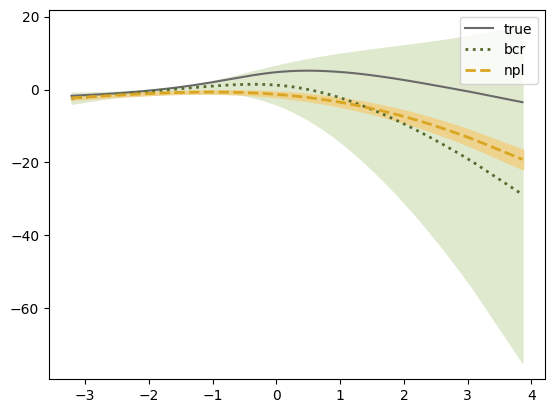

In [14]:
ates_mean = ates.mean(axis=0)
ates_std = ates.std(axis=0)
plt.plot(x_sorted, ates_mean[0,:], label='true', linestyle='solid', color='dimgrey')

plt.plot(x_sorted, ates_mean[2,:], label='bcr', linestyle='dotted', lw=2, color='#556B2F')
plt.fill_between(x_sorted, ates_mean[2,:]-ates_std[2,:], ates_mean[2,:]+ates_std[2,:], color=lighten_color('#556B2F', 0.2))
plt.plot(x_sorted, ates_mean[1,:], label='npl', linestyle = 'dashed', lw=2, color='goldenrod')
plt.fill_between(x_sorted, ates_mean[1,:]-ates_std[1,:], ates_mean[1,:]+ates_std[1,:], lw=2, color=lighten_color('goldenrod',0.5))
plt.legend()

In [15]:
seed = 1
ates = np.zeros((200, 3, len(x)))
x = np.random.randn(500)
knots = np.zeros(30)
for k in range(30):
    knots[k] = ((31-k)*min(x)+k*max(x))/31
path_data = f'./mh_study/sim_data_bcr/sim_data_bcr_{seed}.csv'
data_control, data_treat = process_csv(path_data)
boot_sample = np.loadtxt(folder_path+f'bootstrap_samples_bcr_{seed}.txt')
    # change order of beta to match bcr and theta star 
boot_sample[:, [2, 1]] = boot_sample[:, [1, 2]]
    #bcr_sample = np.loadtxt(folder_path_bcr+f'bcr_sample_{seed}.txt')
bcr_sample = pd.read_csv(folder_path_bcr+f'bcr_sample_{seed}.txt', delim_whitespace=True)
    
mean_boot_sample = boot_sample.mean(axis=0)
mean_bcr_sample = np.asarray(bcr_sample.mean(axis=1))
    
ate = compute_ate(x_sorted, theta_star, knots)
ate_npl = compute_ate(x_sorted, mean_boot_sample, knots)
ate_bcr = compute_ate(x_sorted, mean_bcr_sample, knots)
    
ates[r, 0, :] = ate
ates[r, 1, :] = ate_npl
ates[r, 2, :] = ate_bcr